# Importing Libraries

In [2]:
import sys, numpy as np
import requests, gzip, os, hashlib
from keras.datasets import mnist
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools    
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# Load Data from keras dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Describe Dataset

In [4]:
x_train.size

47040000

In [5]:
x_test.size

7840000

In [6]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
x_train.shape

(60000, 28, 28)

# Visualise Data

In [9]:
sns.set(style='white', context='notebook', palette='deep')

In [10]:
def countplot(values):
  sns.countplot(values)

In [11]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


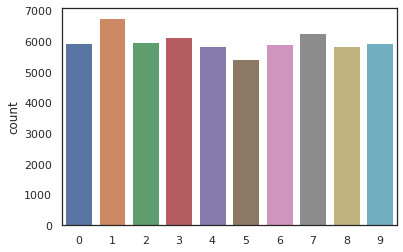

In [12]:
countplot(y_train)

# Sampling and Normalizing of train and test Data

In [13]:
#taking 1000 samples
train_images, y_labels = (x_train[0:1000].reshape(1000,1, 28, 28)/255, y_train[0:1000])
test_images = x_test.reshape(len(x_test),28* 28)/255
train_images = train_images.astype('float32')

# One hot Encoding

In [14]:
#converting integer to binary variables
def convert_to_one_hot_encoding(labels, columns):
  one_hot_labels = np.zeros((len(labels),columns))
  for i, j in enumerate(labels):
    one_hot_labels[i][j] = 1
  return one_hot_labels
   

In [15]:
train_labels = convert_to_one_hot_encoding(y_labels, 10)

In [16]:
test_labels = convert_to_one_hot_encoding(y_test, 10)

# Activation Function and Derivative

In [17]:
relu = lambda x:(x>=0) * x # returns x if x > 0, return 0 otherwise

In [18]:
relu2deriv = lambda x: x>=0 # returns 1 for input > 0, return 0 otherwise

# HyperParameter Initialisation

In [19]:
batch_size = 100
alpha, iterations = (0.001, 400)
pixels_per_image, num_labels, hidden_size = (784, 10, 1024)

# Weights Initialisation

In [20]:
#weights initialization
weights_0_1 = 0.2*np.random.random((pixels_per_image,int(hidden_size))) - 0.1
weights_1_2 = 0.2*np.random.random((int(hidden_size),int(hidden_size*0.2))) - 0.1
weights_2_3 = 0.2*np.random.random((int(hidden_size*0.2),int(hidden_size))) - 0.1
weights_3_4 = 0.2*np.random.random((int(hidden_size),int(hidden_size*0.4))) - 0.1
weights_4_5 = 0.2*np.random.random((int(hidden_size*0.4),num_labels)) - 0.1

# Dropout Code

In [21]:
#Dropout nodes
def dropout_mask(layer, drop):
  return np.random.randint(drop, size=layer.shape)

# Image Augmentation

In [22]:
#modify data for features sycg as rotation, height shift, zoom
def data_augmentation(images, labels, batch_size):
  datagen = ImageDataGenerator(
          featurewise_center=False,  # set input mean to 0 over the dataset
          samplewise_center=False,  # set each sample mean to 0
          featurewise_std_normalization=False,  # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,  # apply ZCA whitening
          rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1, # Randomly zoom image 
          width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,  # randomly flip images
          vertical_flip=False)  # randomly flip images


  datagen.fit(images)
  augmented_result = datagen.flow(images, labels, batch_size)
  train_images_augmented = (np.array([augmented_result[x][0] for x in range(len(augmented_result))])).reshape(int(len(train_images)/batch_size), batch_size, 28*28)
  train_labels_augmented = np.array([augmented_result[x][1] for x in range(len(augmented_result))])
  return train_images_augmented, train_labels_augmented

In [23]:
np.random.seed(2)

# Training and checking Test Accuracy of Model

In [24]:
#dropout on only on one layer
def model(alpha, train_image, train_labels, test_images, test_labels, batch_size, iterations, weights_0_1, weights_1_2, weights_2_3, weights_3_4, weights_4_5):
  train_max_accuracy = 0.0
  for j in range(iterations):

    error, correct_cnt = (0.0, 0)
    for i in range(len(train_image)):

      train_batch_images = train_image[i]
      layer_0 = train_batch_images
      layer_1 = relu(np.dot(layer_0, weights_0_1))
      layer_1_dropout = dropout_mask(layer_1, 2) * 2
      layer_1 *= layer_1_dropout * 0.2
      layer_2 = relu(np.dot(layer_1, weights_1_2))
      layer_2_dropout = dropout_mask(layer_2, 2) * 2
      # layer_2 *= layer_2_dropout * 0.4
      layer_3 = relu(np.dot(layer_2, weights_2_3))
      layer_4 = relu(np.dot(layer_3, weights_3_4))
      layer_5 = np.dot(layer_4, weights_4_5)

      error += np.sum((train_labels[i] - layer_5) ** 2)

      for k in range(batch_size):
        correct_cnt += int(np.argmax(layer_5[k:k+1]) == np.argmax(train_labels[i][k:k+1]))

        layer_5_delta = (train_labels[i] - layer_5)/batch_size
        layer_4_delta = layer_5_delta.dot(weights_4_5.T)* relu2deriv(layer_4)
        layer_3_delta = layer_4_delta.dot(weights_3_4.T)* relu2deriv(layer_3)
        layer_2_delta = layer_3_delta.dot(weights_2_3.T)* relu2deriv(layer_2)
        # layer_2_delta *= layer_2_dropout * 0.4
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)* relu2deriv(layer_1)
        layer_1_delta *= layer_1_dropout * 0.2

        weights_4_5 += alpha * layer_4.T.dot(layer_5_delta)
        weights_3_4 += alpha * layer_3.T.dot(layer_4_delta)
        weights_2_3 += alpha * layer_2.T.dot(layer_3_delta)
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    Y_pred = []
    if(j%10 == 0):
      test_error = 0.0
      test_correct_cnt = 0

      for i in range(len(test_images)):
        layer_0 = test_images[i:i+1]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        layer_2 = relu(np.dot(layer_1,weights_1_2))
        layer_3 = relu(np.dot(layer_2,weights_2_3))
        layer_4 = relu(np.dot(layer_3,weights_3_4))
        layer_5 = np.dot(layer_4,weights_4_5)

        test_error += np.sum((test_labels[i:i+1] - layer_5) ** 2)
        test_correct_cnt += int(np.argmax(layer_5) == np.argmax(test_labels[i:i+1]))
        Y_pred.append(np.argmax(layer_5))
      
      train_accuracy = correct_cnt/ float(len(train_images))
      if train_accuracy > train_max_accuracy:
        train_max_accuracy = train_accuracy
      
      sys.stdout.write("\n" + "I:" + str(j) + " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] + " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+ " Train-Err:" + str(error/ float(len(train_images)))[0:5] + " Train-Acc:" + str(correct_cnt/ float(len(train_images))))
      rounded_labels=np.argmax(test_labels, axis=1)
      confusion_mtx = confusion_matrix(rounded_labels, Y_pred) 
      plot_confusion_matrix(confusion_mtx, classes = range(10))
      print("\n")
  print("Maximum Accuracy achieved is", train_max_accuracy)

In [25]:
train_images_augmented, train_labels_augmented = data_augmentation(train_images, train_labels, batch_size)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1000, 1, 28, 28) (28 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')



I:0 Test-Err:2.316 Test-Acc:0.3124 Train-Err:0.959 Train-Acc:0.115

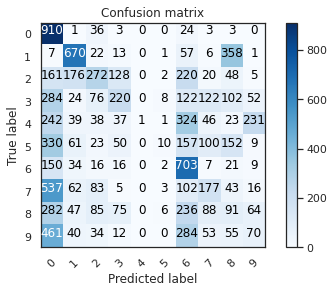




I:10 Test-Err:6.289 Test-Acc:0.722 Train-Err:0.619 Train-Acc:0.634

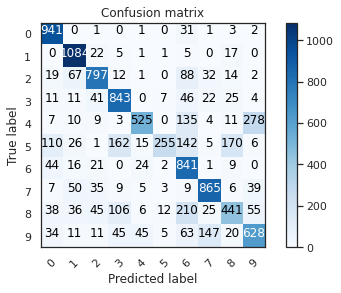




I:20 Test-Err:6.983 Test-Acc:0.7619 Train-Err:0.532 Train-Acc:0.732

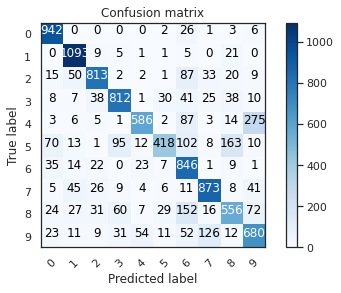




I:30 Test-Err:7.674 Test-Acc:0.7787 Train-Err:0.476 Train-Acc:0.784

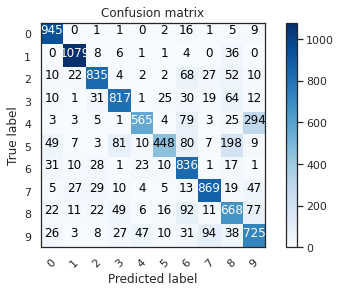




I:40 Test-Err:7.904 Test-Acc:0.7934 Train-Err:0.443 Train-Acc:0.796

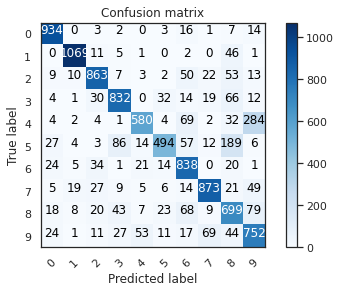




I:50 Test-Err:8.193 Test-Acc:0.798 Train-Err:0.403 Train-Acc:0.837

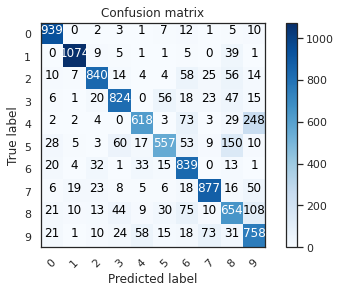




I:60 Test-Err:8.469 Test-Acc:0.7999 Train-Err:0.395 Train-Acc:0.843

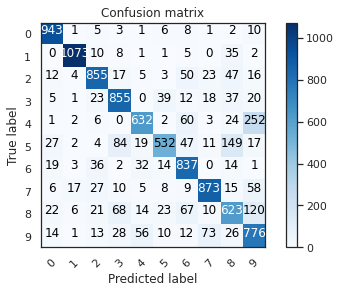




I:70 Test-Err:8.863 Test-Acc:0.7956 Train-Err:0.385 Train-Acc:0.854

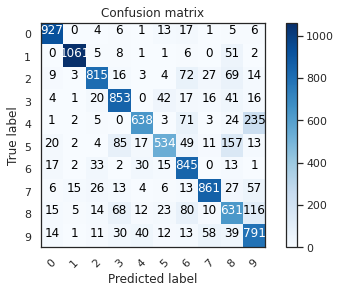




I:80 Test-Err:9.206 Test-Acc:0.7908 Train-Err:0.383 Train-Acc:0.854

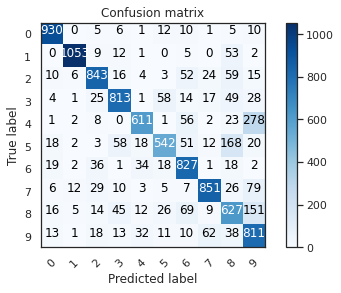




I:90 Test-Err:9.122 Test-Acc:0.7906 Train-Err:0.385 Train-Acc:0.851

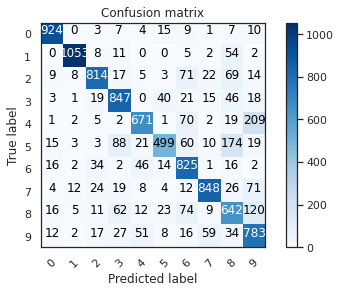




I:100 Test-Err:9.328 Test-Acc:0.7837 Train-Err:0.389 Train-Acc:0.84

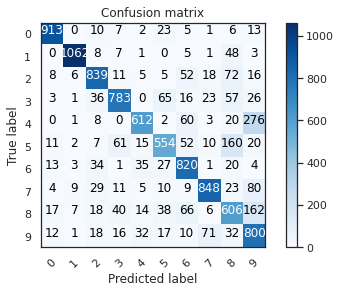




I:110 Test-Err:9.724 Test-Acc:0.7832 Train-Err:0.387 Train-Acc:0.85

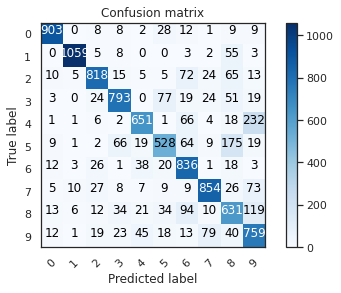




I:120 Test-Err:10.14 Test-Acc:0.7743 Train-Err:0.385 Train-Acc:0.859

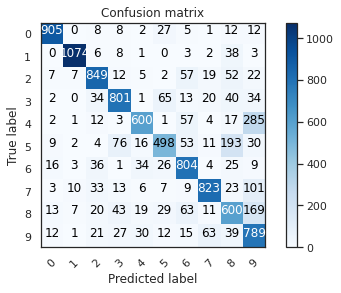




I:130 Test-Err:10.57 Test-Acc:0.7791 Train-Err:0.391 Train-Acc:0.851

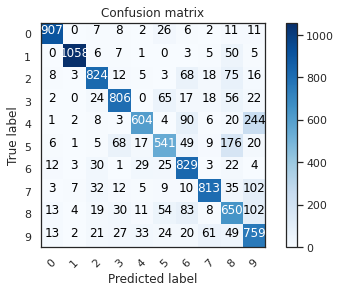




I:140 Test-Err:10.82 Test-Acc:0.7743 Train-Err:0.382 Train-Acc:0.854

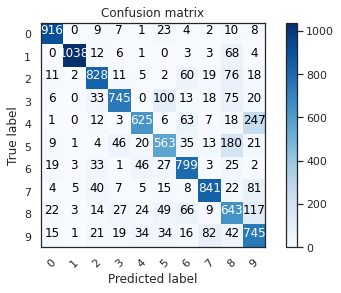




I:150 Test-Err:11.40 Test-Acc:0.7708 Train-Err:0.377 Train-Acc:0.849

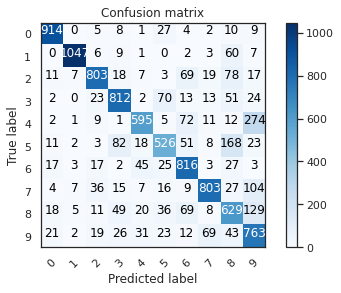




I:160 Test-Err:11.05 Test-Acc:0.7644 Train-Err:0.382 Train-Acc:0.861

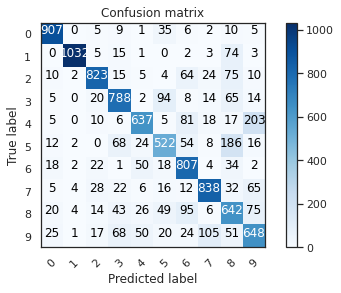




I:170 Test-Err:11.46 Test-Acc:0.7619 Train-Err:0.382 Train-Acc:0.851

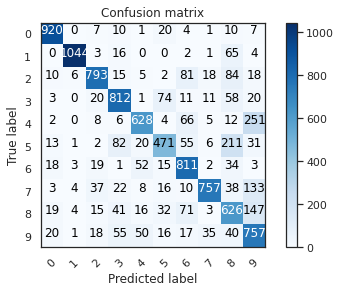




I:180 Test-Err:12.11 Test-Acc:0.7632 Train-Err:0.376 Train-Acc:0.857

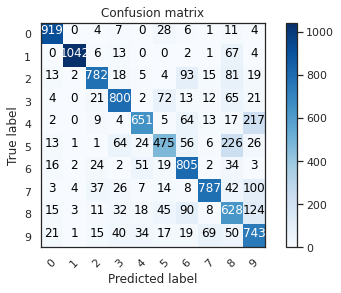




I:190 Test-Err:11.92 Test-Acc:0.7569 Train-Err:0.359 Train-Acc:0.863

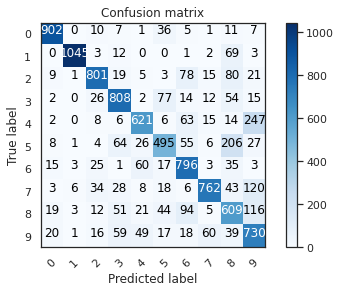




I:200 Test-Err:11.93 Test-Acc:0.7606 Train-Err:0.364 Train-Acc:0.857

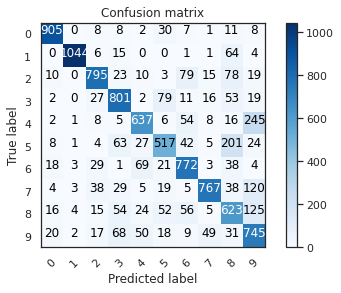




I:210 Test-Err:11.79 Test-Acc:0.7525 Train-Err:0.363 Train-Acc:0.862

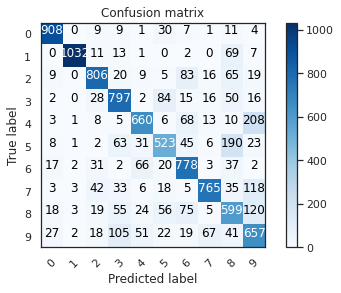




I:220 Test-Err:12.22 Test-Acc:0.7489 Train-Err:0.361 Train-Acc:0.876

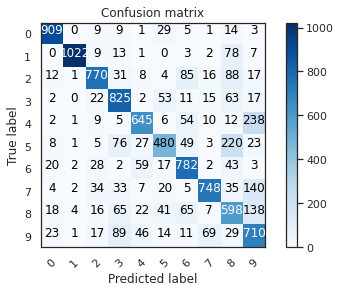




I:230 Test-Err:11.71 Test-Acc:0.7477 Train-Err:0.360 Train-Acc:0.872

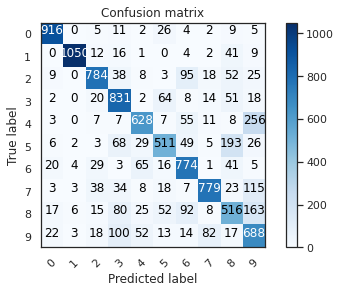




I:240 Test-Err:12.60 Test-Acc:0.7531 Train-Err:0.361 Train-Acc:0.875

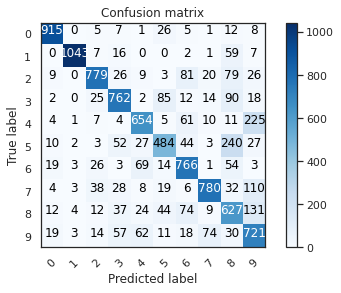




I:250 Test-Err:12.32 Test-Acc:0.7553 Train-Err:0.356 Train-Acc:0.863

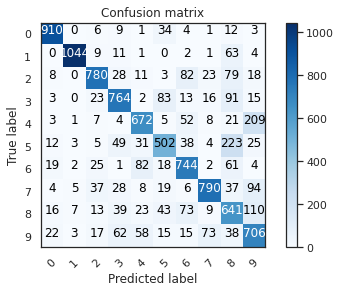




I:260 Test-Err:11.95 Test-Acc:0.7578 Train-Err:0.349 Train-Acc:0.886

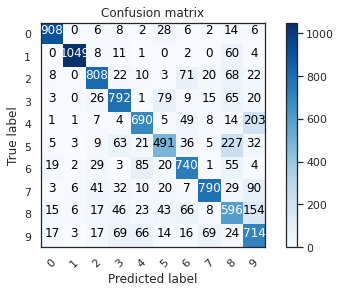




I:270 Test-Err:12.17 Test-Acc:0.7479 Train-Err:0.351 Train-Acc:0.878

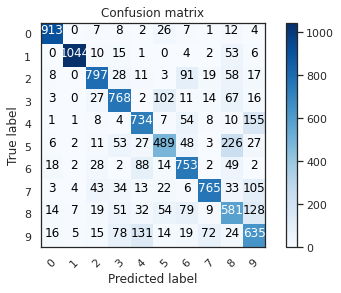




I:280 Test-Err:12.00 Test-Acc:0.7565 Train-Err:0.354 Train-Acc:0.877

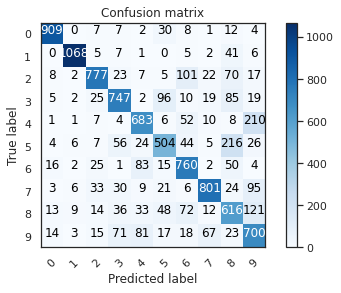




I:290 Test-Err:11.98 Test-Acc:0.7567 Train-Err:0.355 Train-Acc:0.874

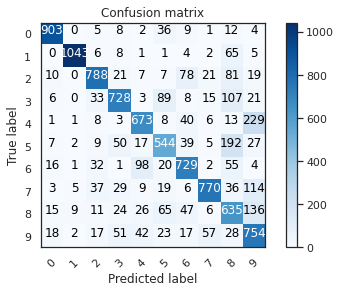




I:300 Test-Err:12.40 Test-Acc:0.748 Train-Err:0.353 Train-Acc:0.873

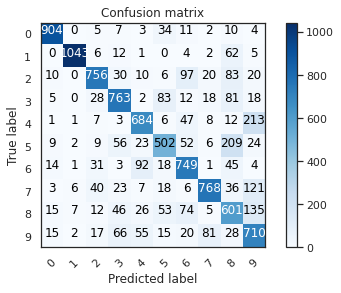




I:310 Test-Err:12.30 Test-Acc:0.7501 Train-Err:0.354 Train-Acc:0.873

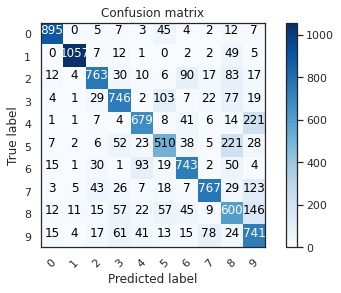




I:320 Test-Err:12.29 Test-Acc:0.747 Train-Err:0.352 Train-Acc:0.876

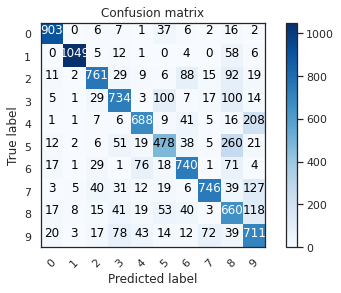




I:330 Test-Err:12.23 Test-Acc:0.7429 Train-Err:0.361 Train-Acc:0.868

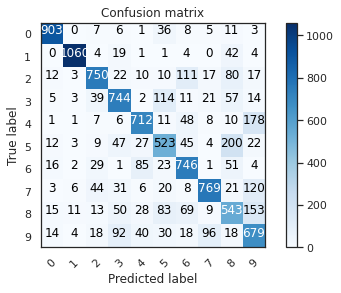




I:340 Test-Err:12.04 Test-Acc:0.7432 Train-Err:0.362 Train-Acc:0.854

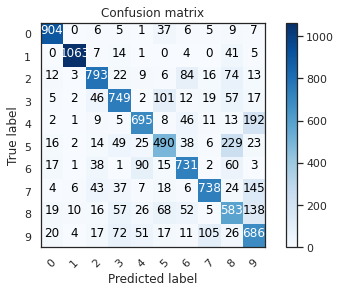




I:350 Test-Err:11.73 Test-Acc:0.7483 Train-Err:0.367 Train-Acc:0.853

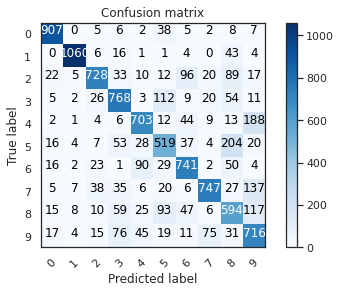




I:360 Test-Err:11.53 Test-Acc:0.7454 Train-Err:0.362 Train-Acc:0.874

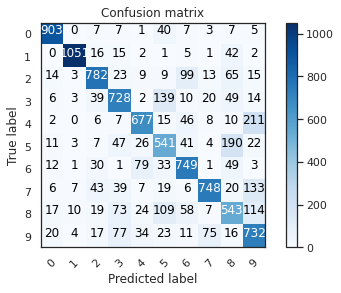




I:370 Test-Err:11.62 Test-Acc:0.7411 Train-Err:0.362 Train-Acc:0.857

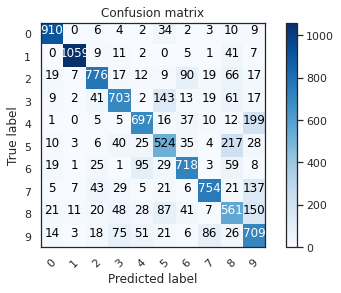




I:380 Test-Err:11.90 Test-Acc:0.7452 Train-Err:0.375 Train-Acc:0.853

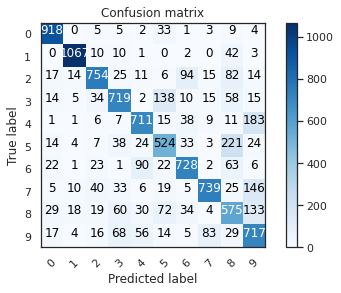




I:390 Test-Err:11.96 Test-Acc:0.7463 Train-Err:0.363 Train-Acc:0.867

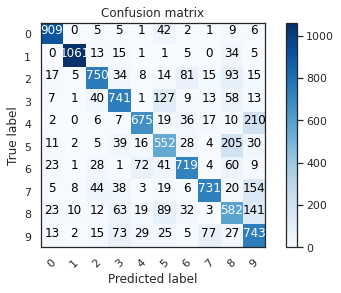



Maximum Accuracy achieved is 0.886


In [26]:
model(alpha, train_images_augmented, train_labels_augmented, test_images, test_labels, batch_size, iterations, weights_0_1, weights_1_2, weights_2_3, weights_3_4, weights_4_5)